## Import Libraries

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import qutip as qt
import tensorflow as tf

from sklearn.model_selection import train_test_split

from qiskit.quantum_info import Statevector, DensityMatrix, entropy, partial_trace
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a p-vector."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def vae_mlp(latent_dim, act_func, f_act):
    encoder_inputs = tf.keras.Input(shape=64)
    x = encoder_inputs
    x = tf.keras.layers.Dense(64, activation=act_func)(x)
    x = tf.keras.layers.Dense(8, activation=act_func)(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = latent_inputs
    x = tf.keras.layers.Dense(8, activation=act_func)(x)
    decoder_outputs = tf.keras.layers.Dense(64, activation=f_act)(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return encoder, decoder

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta_factor, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta_factor
        self.beta_scale = 1
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(
            name="val_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.mean_squared_error(data, reconstruction), axis=-1))

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.beta_scale * self.beta * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def test_step(self, data):
        _, _, z_test = self.encoder(data[0])
        test_reconstruction = self.decoder(z_test)
        val_loss = tf.reduce_mean(
            tf.reduce_sum(tf.keras.losses.mean_squared_error(data[0], test_reconstruction), axis=-1))
        self.val_loss_tracker.update_state(val_loss)
        return {"val_loss": self.val_loss_tracker.result()}

### Set figure properties

In [2]:
fig_size_dim    = 4
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 12
    dpi             = 200

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "sans-serif",
              'font.sans-serif': ["Helvetica"],
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'text.usetex': False,
             }

    plt.rcParams.update(params)
plot_style()

In [3]:
def three_qubit_circuit(theta1, theta2):
    q = QuantumRegister(3,'q')
    circuit = QuantumCircuit(q)
    circuit.h(q[0])
    circuit.cry(theta1,q[0],q[1])
    circuit.h(q[1])
    circuit.cry(theta2,q[0],q[2])
    return circuit

def get_dm(theta1, theta2):
    state = Statevector.from_int(0, 2**3)
    state = state.evolve(three_qubit_circuit(theta1, theta2))
    return DensityMatrix(state)

def get_random_u(n):
    z = np.random.randn(n,n)/np.sqrt(2.0)
    q,r = np.linalg.qr(z)
    d = np.diagonal(r)
    ph = d/np.absolute(d)
    q = np.multiply(q,ph,q)
    return q

def apply_u(dm, U):
    return  U * dm * U.dag()  

def gen_angle_circ(n_points, n_samples, max_epsilon):
    th_scan_template = np.linspace(0, np.pi, n_points)
    th_scan = np.zeros((n_points, n_samples))
    for cnt, theta in enumerate(th_scan_template):
        th_scan[cnt] = theta + max_epsilon * np.random.uniform(-1, 1, size=n_samples)
    return th_scan

def depolarize(dm, alpha):
    return (1 - alpha)*dm  + alpha/2**2 * qt.identity([2,2])

In [4]:
dm = get_dm(np.pi, 0)

dm = qt.Qobj(dm.data, dims=[[2,2,2],[2,2,2]])
dm

# UaUbUc = qt.Qobj(np.kron(np.kron(get_random_u(2),get_random_u(2)),get_random_u(2)), dims = [[2,2,2], [2,2,2]])
# dm_scrambled = apply_u(dm, UaUbUc)

# print(dm_scrambled)

dm.ptrace([1,2])

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.25  0.25  0.25 -0.25]
 [ 0.25  0.25  0.25 -0.25]
 [ 0.25  0.25  0.25 -0.25]
 [-0.25 -0.25 -0.25  0.25]]

In [5]:
a = [0,1,2]
a.remove(2)
print(a)


[0, 1]


In [6]:
num_angles_1 = 20
num_angles_2 = 1
num_samples = 1000

angles1 = np.linspace(0,np.pi,num_angles_1)
angles2 = np.linspace(0,np.pi,num_angles_2)

test_angles = []

density_matrices = np.zeros((num_angles_1,num_angles_2,num_samples,8,8), dtype=np.float64)

concurrence = np.zeros((3,num_angles_1,num_angles_2))
negativity = np.zeros((3,num_angles_1,num_angles_2))

for i, theta1 in enumerate(angles1):
    for j, theta2 in enumerate(angles2):
        # Generate the density matrix for this angle
        dm = get_dm(theta1, theta2)
        dm = qt.Qobj(dm.data,dims=[[2,2,2],[2,2,2]])
    
        for s in range(3):
            qubits = [0,1,2]
            qubits.remove(s)
            concurrence[s][i][j] = qt.concurrence(dm.ptrace(qubits))
            negativity[s][i][j] = qt.negativity(dm, s)
    
        for inx, s in enumerate(range(num_samples)):
            test_angles.append([theta1,theta2])
            # Generate a new random scrambling
            U = qt.Qobj(np.kron(np.kron(get_random_u(2),get_random_u(2)),get_random_u(2)), dims = [[2, 2, 2], [2, 2, 2]])
            # Store the density matrix
            density_matrices[i,j,inx] = np.real(apply_u(dm, U))
            
density_matrices = np.reshape(density_matrices,(num_angles_1*num_angles_2*num_samples,64))

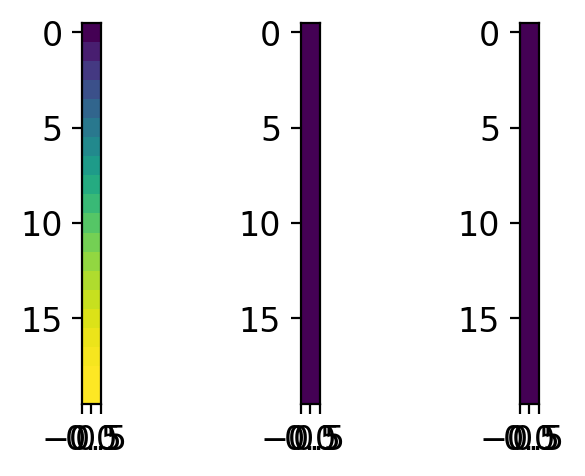

In [7]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(concurrence[0])
ax[1].imshow(concurrence[1])
ax[2].imshow(concurrence[2])

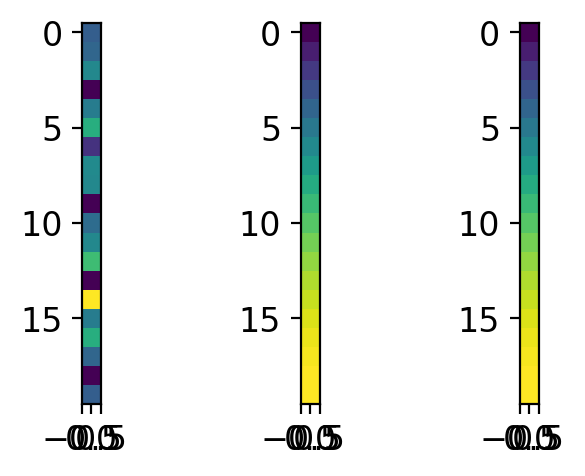

In [8]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(negativity[0])
ax[1].imshow(negativity[1])
ax[2].imshow(negativity[2])

### Create training and test set

In [9]:
#testangles = np.array([[a,b] * num_samples for a in angles for b in angles])
print(np.array(test_angles).shape)
print(density_matrices.shape)

(20000, 2)
(20000, 64)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(density_matrices, test_angles, random_state=42,shuffle=True)

In [15]:
concurrence_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(8,8),dims=[[2,2,2],[2,2,2]]).ptrace([1,2])) for dm in X_test])
# negativity_arr = np.array([qt.negativity(qt.Qobj(dm.reshape(8,8),dims=[[2,2,2],[2,2,2]]), 0)) for dm in X_test])
print(concurrence_arr.shape)

(5000,)


Define Hyperparameters:

In [96]:
batch_size = 32
beta = 0.1
learning_rate = 1e-4
lat_dim = 3
hidden_act = "tanh"
final_act = "linear"

Load trained VAE:

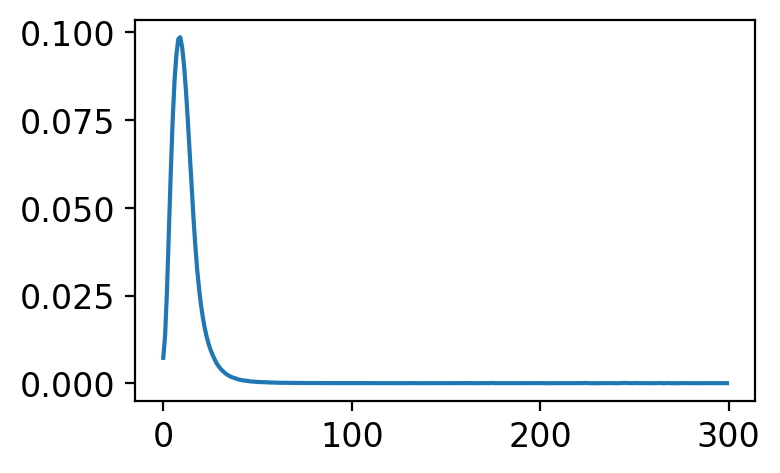

In [97]:
encoder, decoder = vae_mlp(lat_dim, hidden_act, final_act)

vae_noisy = VAE(encoder, decoder, beta)
vae_noisy.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))


hist = vae_noisy.fit(X_test, epochs=300, batch_size=batch_size, verbose=0) 
plt.plot(hist.history["kl_loss"])

In [98]:
z_mean, z_log_var, z = vae_noisy.encoder.predict(X_test)

157/157 [==============================] - 0s 551us/step


Investigate Latent Space

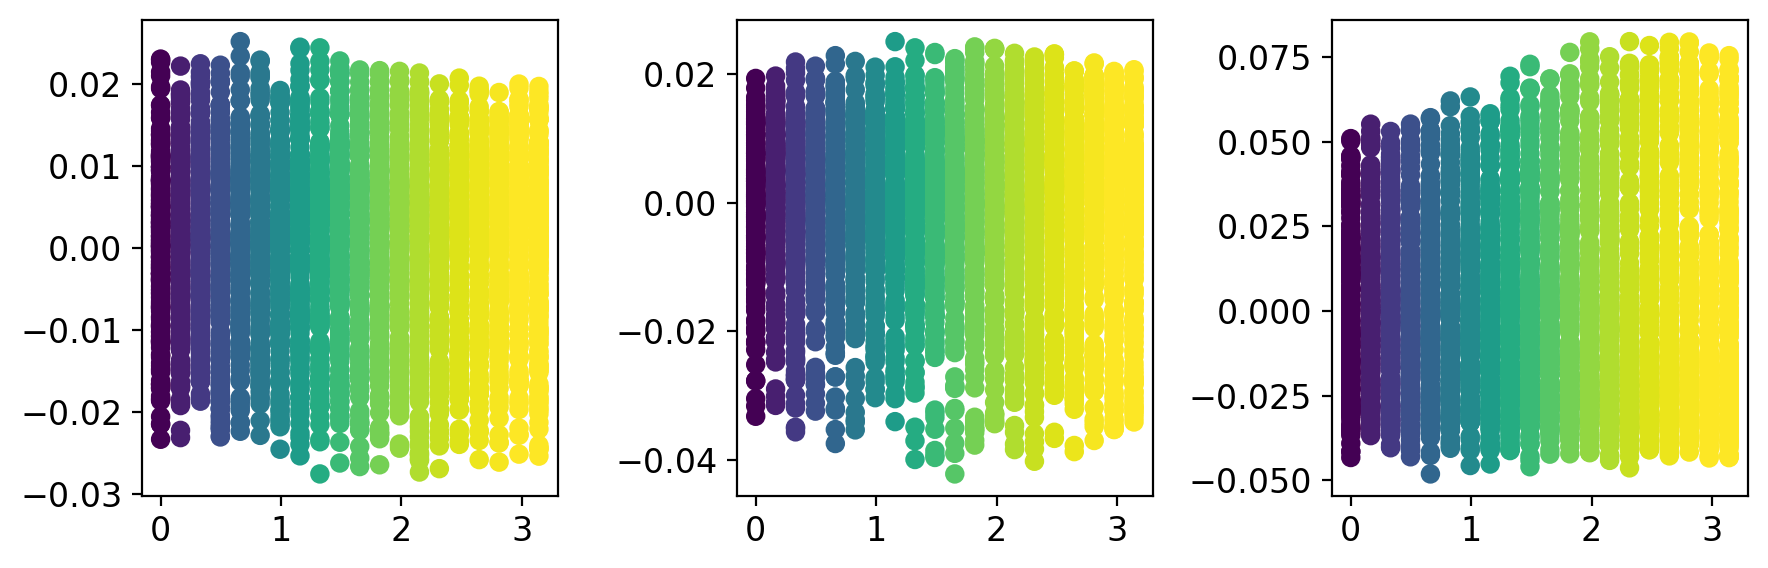

In [99]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].scatter(np.array(y_test)[:,0],z_mean[:,0],c=concurrence_arr)#,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)
ax[1].scatter(np.array(y_test)[:,0],z_mean[:,1],c=concurrence_arr)#,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)
ax[2].scatter(np.array(y_test)[:,0],z_mean[:,2],c=concurrence_arr)#,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)

fig.tight_layout()

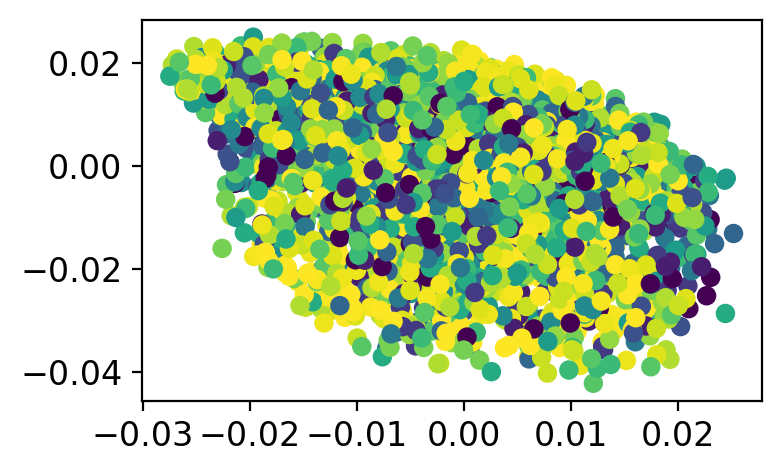

In [100]:
plt.scatter(z_mean[:,0], z_mean[:,1],c=concurrence_arr)

Text(0, 0.5, '$Z_2$')

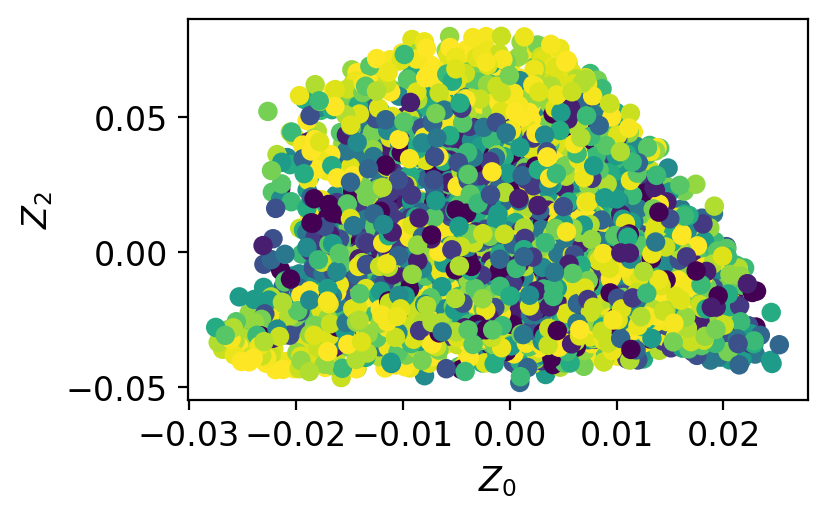

In [101]:
plt.scatter(z_mean[:,0], z_mean[:,2],c=concurrence_arr)
plt.xlabel("$Z_0$")
plt.ylabel("$Z_2$")

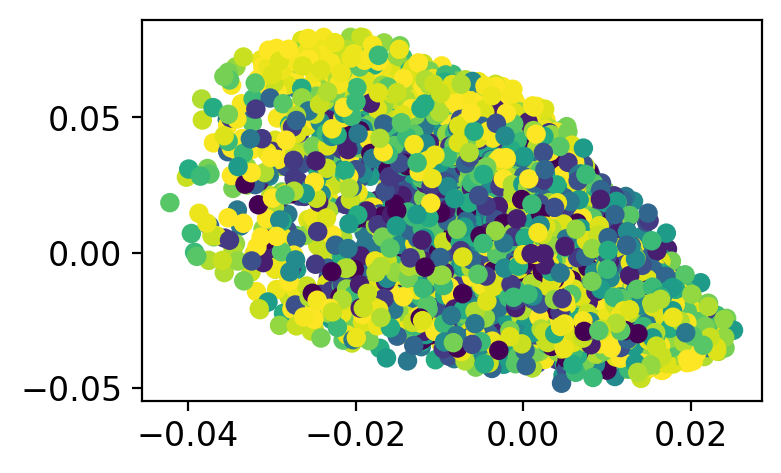

In [102]:
plt.scatter(z_mean[:,1], z_mean[:,2],c=concurrence_arr)

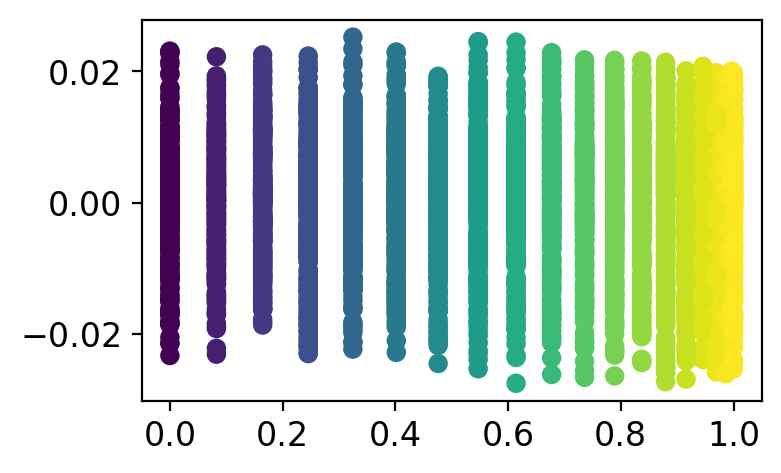

In [103]:
plt.scatter(concurrence_arr, z_mean[:,0], c=concurrence_arr)